In [1]:
import glob
import os
import random
from datetime import datetime

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import datasets, layers, models

from spec_input_generator import gen, gen_eval
# import spectrogram
# from spectrogram import generate_spec
# from spectrogram import truncate_spec
# from spectrogram import mask_spec
# from spectrogram import add_noise
# from spectrogram import path_to_preprocessing
from spectrogram_class import spectrogram
import tensorflow.python.platform.build_info as build
from tensorflow.python.client import device_lib
from spec_generator_sequence import spec_generator

In [2]:
print(build.build_info['cuda_version'])

11.2


In [3]:
device_lib.list_local_devices()

2022-07-21 15:09:55.394992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 15:09:55.432653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:55.471573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:55.472277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3630781273124661230
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3288203264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4733778047854338711
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-21 15:09:57.267927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:57.268842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:57.269555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:57.270193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:57.270606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

True

135 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
gpu_devices

2022-07-21 15:09:57.497783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:57.498368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:57.498855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
meta_df = pd.read_csv('../data/OrchideaSOL_metadata.csv')

In [7]:
meta_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
0,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,f,3.0,0.0,S,Sordina,NaN,False,2
1,Brass/Bass_Tuba+sordina/ordinario/BTb+S-ord-A#...,Brass,Brass,BTb,Bass Tuba,ord,ordinario,A#0,22.0,p,1.0,0.0,S,Sordina,NaN,True,0


In [8]:
# meta_df_dummy = meta_df[['Path', 'Instrument (in full)']]
# meta_df_dummy['_ins'] = meta_df_dummy['Instrument (in full)']
# meta_df_dummy = pd.get_dummies(meta_df_dummy, columns=['Instrument (in full)'])

In [9]:
# meta_df_dummy.head(2)

In [10]:
train_df, test_df = train_test_split(meta_df, stratify=meta_df['Instrument (in full)'], 
                                        train_size=0.8)

In [11]:
train_df.head(2)

,Path,Family (abbr.),Family (in full),Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID (if applicable),Dynamics,Dynamics ID (if applicable),Instance ID,Mute (abbr.),Mute (in full),String ID (if applicable),Needed digital retuning,Fold
2165,Brass/Trumpet_C/flatterzunge/TpC-flatt-G4-ff-N...,Brass,Brass,TpC,Trumpet in C,flatt,flatterzunge,G4,67.0,ff,4.0,0.0,N,None,NaN,True,2
11270,Winds/Bassoon+sordina/ordinario/Bn+S-ord-D#5-m...,Winds,Woodwinds,Bn,Bassoon,ord,ordinario,D#5,75.0,mf,2.0,0.0,S,Sordina,NaN,False,4


In [12]:
list(sorted(set(test_df.sample(1).columns)- set(['Path'])))

['Dynamics',
 'Dynamics ID (if applicable)',
 'Family (abbr.)',
 'Family (in full)',
 'Fold',
 'Instance ID',
 'Instrument (abbr.)',
 'Instrument (in full)',
 'Mute (abbr.)',
 'Mute (in full)',
 'Needed digital retuning',
 'Pitch',
 'Pitch ID (if applicable)',
 'String ID (if applicable)',
 'Technique (abbr.)',
 'Technique (in full)']

In [13]:
list(sorted(set(test_df.columns)-set(['Path'])))

['Dynamics',
 'Dynamics ID (if applicable)',
 'Family (abbr.)',
 'Family (in full)',
 'Fold',
 'Instance ID',
 'Instrument (abbr.)',
 'Instrument (in full)',
 'Mute (abbr.)',
 'Mute (in full)',
 'Needed digital retuning',
 'Pitch',
 'Pitch ID (if applicable)',
 'String ID (if applicable)',
 'Technique (abbr.)',
 'Technique (in full)']

In [14]:
sample = next(gen(train_df, return_class = True))

In [15]:
spec_shape = sample[0].spec.shape
spec_shape

(256, 500, 1)

In [16]:
next(gen_eval(test_df))[0].shape

(256, 500, 1)

In [17]:

# BATCH_SIZE = 16 

# train_generator = (tf.data.Dataset.from_generator(lambda: gen(train_df), output_types=(tf.complex64, tf.int64), 
#                  output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)

# eval_generator = (tf.data.Dataset.from_generator(lambda: gen_eval(test_df), output_types=(tf.complex64, tf.int64), 
#                  output_shapes = ((spec_shape[0], spec_shape[1], 1), (16)))).batch(BATCH_SIZE)


In [18]:
BATCH_SIZE = 32

train_generator = (tf.data.Dataset.from_generator(lambda: spec_generator(train_df, BATCH_SIZE), output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, spec_shape[0], spec_shape[1], 1), 
                 (BATCH_SIZE, 16)))).prefetch((tf.data.experimental.AUTOTUNE))

eval_generator = (tf.data.Dataset.from_generator(lambda: spec_generator(test_df, BATCH_SIZE), 
                    output_types=(tf.complex64, tf.int64), 
                 output_shapes = ((BATCH_SIZE, spec_shape[0], spec_shape[1], 1), 
                 (BATCH_SIZE, 16)))).prefetch((tf.data.experimental.AUTOTUNE))


2022-07-21 15:09:59.265737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:59.266319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:59.266771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:59.267255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 15:09:59.267700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [19]:
train_generator

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 256, 500, 1), dtype=tf.complex64, name=None), TensorSpec(shape=(32, 16), dtype=tf.int64, name=None))>

In [27]:

model_2conv = models.Sequential()
model_2conv.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1),
                     batch_size = BATCH_SIZE, dtype = tf.float32))
model_2conv.add(layers.Conv2D(30, (150, 300), activation='relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(l2=0.01)))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model_2conv.add(layers.MaxPool2D((2, 3)))
model_2conv.add(layers.Conv2D(30, (15, 30), activation = 'relu',
                                kernel_regularizer = tf.keras.regularizers.L2(l2=0.01)))
model_2conv.add(layers.MaxPool2D(2, 3))
model_2conv.add(layers.Flatten())
model_2conv.add(layers.Dropout(0.2))
model_2conv.add(layers.Dense(50, activation = 'relu'))
model_2conv.add(layers.Dropout(0.2))
model_2conv.add(layers.Dense(16, activation = 'softmax'))

model_2conv.build()

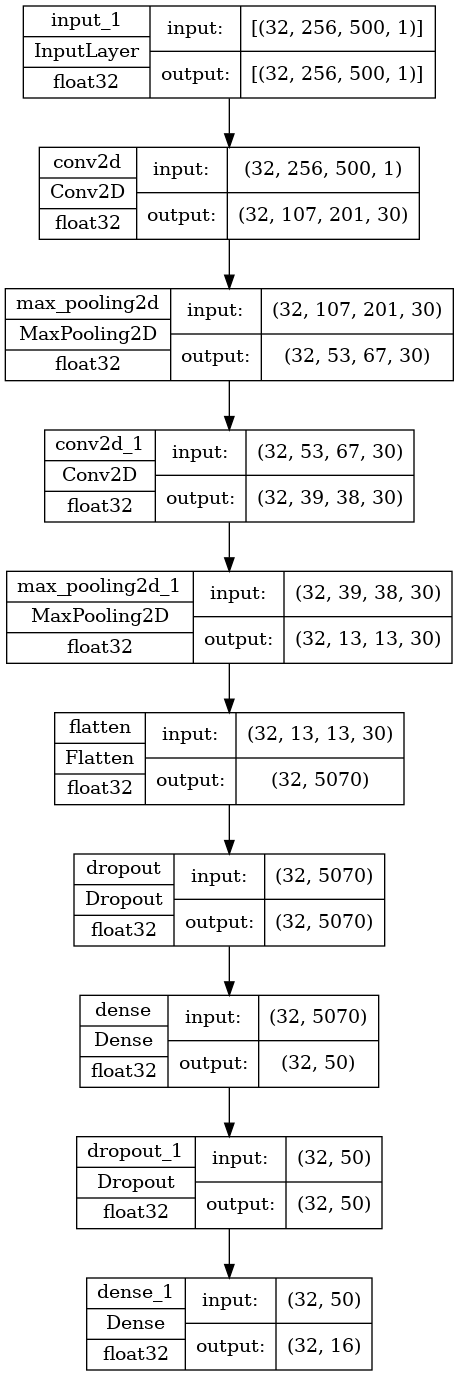

In [21]:
tf.keras.utils.plot_model(model_2conv, show_shapes = True, show_dtype= True)

In [33]:

model_2conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
model_2conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 107, 201, 30)        1350030   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 53, 67, 30)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 39, 38, 30)          405030    
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 13, 13, 30)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 5070)                0         
                                                                 
 dropout (Dropout)           (32, 5070)                0

In [30]:
 model_2conv = tf.keras.models.load_model('../models/2conv/six/')

In [35]:
model_2conv

In [36]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    f"../models/baseline_checkpoint/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{{epoch:02d}}_model_2conv", 
                                                    monitor='val_accuracy')
early_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 2)


history = model_2conv.fit(train_generator, epochs = 4, verbose=1, 
                    validation_data = eval_generator,
                    validation_steps = 10, validation_freq= 2, 
                    use_multiprocessing=True, workers = 2, callbacks=[ckpt_callback, early_callback])

Epoch 1/4
    293/Unknown - 1463s 5s/step - loss: 13463.8213 - accuracy: 0.1454

KeyboardInterrupt: 

In [37]:
model_2conv.save('../models/2conv/six/')

INFO:tensorflow:Assets written to: ../models/2conv/six/assets


INFO:tensorflow:Assets written to: ../models/2conv/six/assets


In [ ]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.config.list_logical_devices(
    device_type=None
)

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [ ]:
print(tf.version)
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)


<module 'tensorflow._api.v2.version' from '/home/shiya/anaconda3/envs/music/lib/python3.8/site-packages/tensorflow/_api/v2/version/__init__.py'>
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
CUDA_VISIBLE_DEVICES=""

In [ ]:
# model_2conv.save('../models/2conv/fifth/')

INFO:tensorflow:Assets written to: ../models/2conv/fifth/assets


INFO:tensorflow:Assets written to: ../models/2conv/fifth/assets


In [ ]:
history.history['val_accuracy']

[0.48100000619888306, 0.6660000085830688, 0.746999979019165]

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

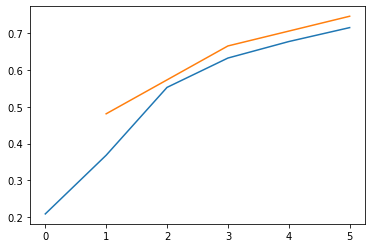

In [ ]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot([1, 3, 5], history.history['val_accuracy'], label='val_accuracy')

Softmax 

In [ ]:


model_2conv_softmax_entropy = models.Sequential()
model_2conv_softmax_entropy.add(layers.InputLayer((spec_shape[0], spec_shape[1], 1),
                     batch_size = BATCH_SIZE, dtype = tf.float32))
model_2conv_softmax_entropy.add(layers.Conv2D(30, (150, 300), activation='relu', 
                    kernel_regularizer = tf.keras.regularizers.L2(l2=0.01)))
# , input_shape = (spec_shape[0], spec_shape[1], 1)))
model_2conv_softmax_entropy.add(layers.MaxPool2D((2, 3)))
model_2conv_softmax_entropy.add(layers.Conv2D(30, (15, 30), activation = 'relu',
                                kernel_regularizer = tf.keras.regularizers.L2(l2=0.01)))
model_2conv_softmax_entropy.add(layers.MaxPool2D(2, 3))
model_2conv_softmax_entropy.add(layers.Flatten())
model_2conv_softmax_entropy.add(layers.Dropout(0.2))
model_2conv_softmax_entropy.add(layers.Dense(50, activation = 'relu'))
model_2conv_softmax_entropy.add(layers.Dropout(0.2))
model_2conv_softmax_entropy.add(layers.Dense(16, activation = 'softmax'))

model_2conv_softmax_entropy.build()

In [ ]:

model_2conv_softmax_entropym.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])